## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Computing the camera calibration

##### Cell #1

In [6]:
import numpy as np
import cv2
import os
import re
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
#%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx = 9
ny = 6
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:ny,0:nx].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
imgpoints = [] # 2d points in image plane.
image_path = 'camera_cal'
file_count = 0

# for each calibration image file in 'camera_cal'
for file in [f for f in os.listdir(image_path) if f.startswith("calibration") and f.endswith('.jpg')]:
    image = cv2.imread(os.path.join(image_path, file))
    
    # Convert image to grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners                                                                                                                                                                        
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
        file_out = re.split('.jpg', file)[0] + '_cornersdrawn.jpg'
        cv2.imwrite(os.path.join('output_images', file_out), image)
        file_count += 1

objpoints = np.array([objp]*file_count) # 3d points in real world space

# Calibrate the camera
retval, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

if retval >= 0:
    print('Calibration is successful!')
    # Saving camera parameters to pickle file
    camera_params = { "mtx": mtx, \
                      "dist": dist, \
                      "rvecs": rvecs, \
                      "tvecs": tvecs }
    with open('camera_params.p', 'wb') as pf:
        pickle.dump(camera_params, pf)
        print('pickle file saved successfully!')
        pf.close()
else:
    print('Something went wrong with the calibration...')

(54, 1, 2)
Calibration is successful!
pickle file saved successfully!


## Applying distorsion correction

##### Cell #2

In [ ]:
import cv2
import os
import re
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
#%matplotlib qt

# Restore previously found values
if os.path.isfile('camera_params.p'):
    with open('camera_params.p', 'rb') as pf:
        camera_params = pickle.load(pf)
        mtx, dist, rvecs, tvecs = camera_params["mtx"], camera_params["dist"], \
                                  camera_params["rvecs"], camera_params["tvecs"]
        print('pickle file restored successfully!')
        pf.close()

# Undistort the calibration images, just for putting them in the writeup
image_path = 'camera_cal'
for file in [f for f in os.listdir(image_path) if f.startswith("calibration") and f.endswith('.jpg')]:
    image = cv2.imread(os.path.join(image_path, file))
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    file_out = re.split('.jpg', file)[0] + '_undistort.jpg'
    cv2.imwrite(os.path.join('output_images', file_out), undist)
    if (file.endswith('calibration2.jpg') or file.endswith('calibration13.jpg')) and False: # see if these
        plt.figure()                                                                        # are necessary
        plt.imshow(undist)

# Undistort the example images        
image_path = 'test_images'
for file in [f for f in os.listdir(image_path) if f.endswith('.jpg')]:
    image = cv2.imread(os.path.join(image_path, file))
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    file_out = re.split('.jpg', file)[0] + '_undistort.jpg'
    cv2.imwrite(os.path.join('output_images', file_out), undist)

## Creating a thresholded binary image

#### Definition of processing blocks and ultimate pipeline

##### Cell #3

In [1]:
import numpy as np
import cv2

def sobel_x(channel, ker_size=3):
    return cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=ker_size)

def sobel_y(channel, ker_size=3):
    return cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=ker_size)

def scale_thresh_image(channel, thresh=(0, 255)):
    scaled_ch = np.uint8(255*channel/np.max(channel))
    binary_img = np.zeros_like(scaled_ch)
    binary_img[(scaled_ch >= thresh[0]) & (scaled_ch < thresh[1])] = 1
    return binary_img

def sobel_thresh(channel, orient, ker_size=3, thresh=(0, 255)):
    if orient is 'x':
        sobel = sobel_x(channel, ker_size)
    elif orient is 'y':
        sobel = sobel_y(channel, ker_size)
    else:
        print('invalid sobel orientation')
        exit(-1)
    abs_sobel = np.absolute(sobel)
    return scale_thresh_image(abs_sobel, thresh)

def mag_thresh(channel, ker_size=3, thresh=(0, 255)):
    sobelx = sobel_x(channel, ker_size)
    sobely = sobel_y(channel, ker_size)
    mag_sobel = np.sqrt(sobelx**2 + sobely**2)
    return scale_thresh_image(mag_sobel, thresh)
    
def dir_thresh(channel, ker_size=3, thresh=(-np.pi*70/180, np.pi*70/180)):
    sobelx = sobel_x(channel, ker_size)
    sobely = sobel_y(channel, ker_size)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    arctan_sobel = np.arctan2(abs_sobely, abs_sobelx)
    binary_img = np.zeros_like(arctan_sobel)
    binary_img[(arctan_sobel >= thresh[0]) & (arctan_sobel < thresh[1])] = 1
    return binary_img

def thresholding_pipeline(img, Debug=False):
    # Convert to HSL color space
    hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsl[:,:,0]
    l_channel = hsl[:,:,1]
    s_channel = hsl[:,:,2]

    # Convert to gray scale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY).astype(np.int16)

    # Thresholded scaled gray scale
    thresh_scale_gray = scale_thresh_image(gray, (190, 255))

    # Thresholded sobel x on S channel
    sobelx_s = sobel_thresh(s_channel, 'x', 11, (40, 100))

    binary_output = np.zeros_like(gray).astype(np.uint8)
    
    result_dict = {}
    # expand result dict with other combinations of binary images for debugging purposes
    if Debug:
        # Thresholded scaled S channel
        thresh_scale_s = scale_thresh_image(s_channel, (200, 255)) 
        # Thresholded scaled L channel
        thresh_scale_l = scale_thresh_image(l_channel, (200, 255))
        # Thresholded sobel x on gray channel
        sobelx_gray = sobel_thresh(gray, 'x', 13, (30, 80))
        # Thresholded directional sobel on S channel
        dir_thresh_s = dir_thresh(s_channel, 7, (np.pi*40/180, np.pi*70/180))
        
        # Putting debug thresholded images in returned dictionary
        result_dict["thresh_scale_l"] = thresh_scale_l
        result_dict["thresh_scale_s"] = thresh_scale_s
        result_dict["thresh_scale_gray"] = thresh_scale_gray
        result_dict["sobelx_gray"] = sobelx_gray
        result_dict["sobelx_s"] = sobelx_s
        result_dict["dir_thresh_s"] = dir_thresh_s
        
        binary_output[(thresh_scale_gray == 1) | (sobelx_s == 1)] = 1
        result_dict["binary_output_tsg_sxs"] = binary_output
        binary_output = np.zeros_like(gray).astype(np.uint8)
        binary_output[(thresh_scale_s == 1) | (thresh_scale_gray == 1) | (sobelx_s == 1)] = 1
        result_dict["binary_output_tss_tsg_sxs"] = binary_output
        binary_output = np.zeros_like(gray).astype(np.uint8)
        binary_output[(thresh_scale_l == 1) | (sobelx_gray == 1)] = 1
        result_dict["binary_output_tsl_sxg"] = binary_output
        binary_output = np.zeros_like(gray).astype(np.uint8)
        binary_output[(thresh_scale_l == 1) | (sobelx_s == 1)] = 1
        result_dict["binary_output_tsl_sxs"] = binary_output
    else:   
        binary_output[(thresh_scale_gray == 1) | (sobelx_s == 1)] = 1
        result_dict["binary_output_tsg_sxs"] = binary_output

    return result_dict

#### Running single blocks and complete pipeline on example images

##### Cell #4

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pickle
#%matplotlib inline
%matplotlib qt

image_path = 'output_images'
binary_img_list = []

for file in [f for f in os.listdir(image_path) if \
             (f.startswith('straight_lines') or f.startswith('test'))]:

    image = mpimg.imread(os.path.join(image_path, file))
    binary_img = thresholding_pipeline(image)
    binary_img = binary_img["binary_output_tsg_sxs"]
    binary_img_list.append(binary_img)
    fig = plt.figure()
    plt.imshow(binary_img, cmap='gray')
    
# Saving binary images to pickle file
with open('binary_images.p', 'wb') as pf:
    pickle.dump(binary_img_list, pf)
    print('pickle file saved successfully!')
    pf.close()

pickle file saved successfully!


## Applying perspective transform

##### Cell #5

pickle file restored successfully!
pickle file saved successfully!
pickle file saved successfully!


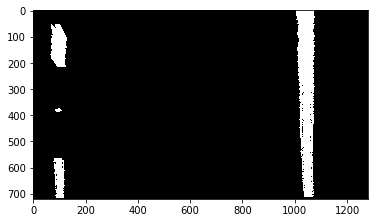

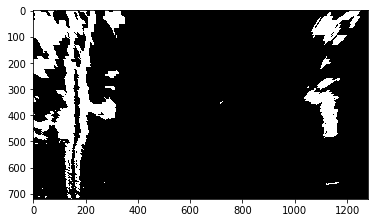

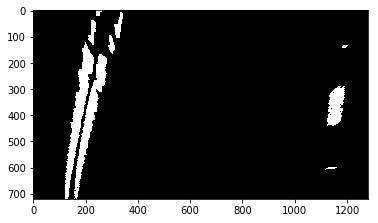

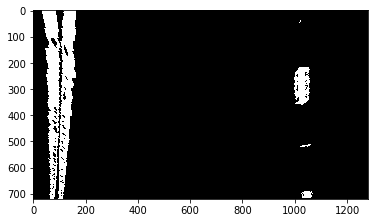

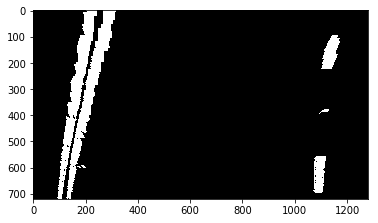

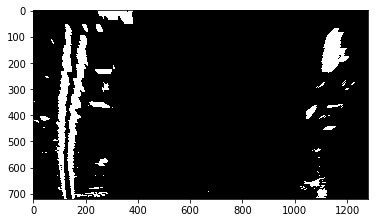

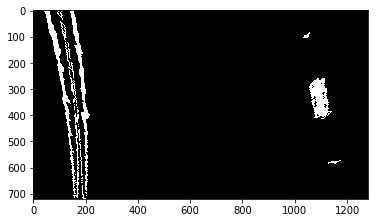

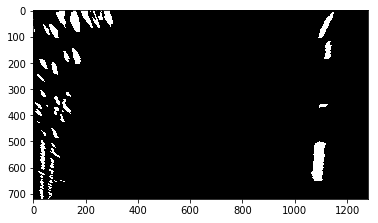

In [2]:
import os
import pickle
import cv2
import matplotlib.pyplot as plt
%matplotlib inline                                                                                                                                                                                  
#%matplotlib qt

# Restore previously saved binary images
if os.path.isfile('binary_images.p'):
    with open('binary_images.p', 'rb') as pf:
        binary_img_list = pickle.load(pf)
        print('pickle file restored successfully!')
        pf.close()

# The source points were eyeballed from the binary images resulting from processing
# the test images
src_points = np.float32(
    [[547,  472],
     [764,  472],
     [1280, 702],
     [290,  702]])

# The destination points correspond to a full 1280x720 frame
dst_points = np.float32(
    [[0,     0],
     [1280,  0],
     [1280, 720],
     [155.5,720]])

# Compute the transform and inverse transform matrices
M = cv2.getPerspectiveTransform(src_points, dst_points)
Minv = cv2.getPerspectiveTransform(dst_points, src_points)
warped_img_list = []

for idx in range(0,8):
    image = binary_img_list[idx]
    warped = cv2.warpPerspective(image, M, image.shape[::-1], flags=cv2.INTER_LINEAR)
    warped_img_list.append(warped)
    fig = plt.figure()
    plt.imshow(warped, cmap='gray')
    
# Saving warped images to pickle file
with open('warped_images.p', 'wb') as pf:
    pickle.dump(warped_img_list, pf)
    print('pickle file saved successfully!')
    pf.close()
# Saving transform matrices to pickle file
transform_matrices = { "M": M, "Minv": Minv }
with open('transform_matrices.p', 'wb') as pf:
    pickle.dump(transform_matrices, pf)
    print('pickle file saved successfully!')
    pf.close()

## Detecting lane boundaries

##### Cell #6

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline                                                                                                                                                                                  
#%matplotlib qt


def find_lanes_full_search(image, nwindows=9, margin=100, minpix=50, Debug=False):

    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    left_rectangle_coords = []
    right_rectangle_coords = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        left_rectangle_coords.append((win_xleft_low,win_y_low,win_xleft_high,win_y_high))
        right_rectangle_coords.append((win_xright_low,win_y_low,win_xright_high,win_y_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    result_dict = {}
    # Extract left and right line pixel positions
    result_dict["leftx"] = nonzerox[left_lane_inds]
    result_dict["lefty"] = nonzeroy[left_lane_inds]
    result_dict["rightx"] = nonzerox[right_lane_inds]
    result_dict["righty"] = nonzeroy[right_lane_inds]
    if Debug:
        result_dict["left_rectangle_coords"] = left_rectangle_coords
        result_dict["right_rectangle_coords"] = right_rectangle_coords
    
    return result_dict

    
def find_lane_quick_search(image, left_fit, right_fit, margin=100):
    
    # Identify the nonzero pixels in x and y within a margin from the previously fit line
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) \
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) \
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    result_dict = {}
    # Extract left and right line pixel positions
    result_dict["leftx"] = nonzerox[left_lane_inds]
    result_dict["lefty"] = nonzeroy[left_lane_inds]
    result_dict["rightx"] = nonzerox[right_lane_inds]
    result_dict["righty"] = nonzeroy[right_lane_inds]
    
    return result_dict

#### To demonstrate the full lane search, here follows the application of the latter to all example images

##### Cell #7

In [16]:
import os
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib qt

# Restore previously saved warped images
if os.path.isfile('warped_images.p'):
    with open('warped_images.p', 'rb') as pf:
        warped_img_list = pickle.load(pf)
        print('pickle file restored successfully!')
        pf.close()

# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Choose the number of sliding windows
nwindows = 9

leftx_test_images = []
lefty_test_images = []
rightx_test_images = []
righty_test_images = []

for idx in range(0,8):
    
    # Perform full lane search
    ret_dict = find_lanes_full_search(warped_img_list[idx], nwindows, margin, minpix, Debug=True)
    
    leftx = ret_dict["leftx"]
    lefty = ret_dict["lefty"]
    rightx = ret_dict["rightx"]
    righty = ret_dict["righty"]
    leftrect_coords = ret_dict["left_rectangle_coords"]
    rightrect_coords = ret_dict["right_rectangle_coords"]
    
    leftx_test_images.append(leftx)
    lefty_test_images.append(lefty)
    rightx_test_images.append(rightx)
    righty_test_images.append(righty)
    
    # Image canvas to plot lanes data
    out_img = np.dstack((warped_img_list[idx], warped_img_list[idx], warped_img_list[idx]))*255
    
    # Draw the windows on the visualization image
    for window in range(nwindows):
        cv2.rectangle(out_img,(leftrect_coords[window][0],leftrect_coords[window][1]), \
                              (leftrect_coords[window][2],leftrect_coords[window][3]), (0,255,0), 2)
        cv2.rectangle(out_img,(rightrect_coords[window][0],rightrect_coords[window][1]), \
                              (rightrect_coords[window][2],rightrect_coords[window][3]), (0,255,0), 2)

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_img_list[idx].shape[0]-1, warped_img_list[idx].shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Color points detected in each lane rectangular search area
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # Plot everything on out_img
    plt.figure()
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

# Saving curve points to pickle file
lane_curve_points = { "leftx_test_images": leftx_test_images, \
                      "lefty_test_images": lefty_test_images, \
                      "rightx_test_images": rightx_test_images, \
                      "righty_test_images": righty_test_images }
with open('lane_curve_points.p', 'wb') as pf:
    pickle.dump(lane_curve_points, pf)
    print('pickle file saved successfully!')
    pf.close()

pickle file restored successfully!
pickle file saved successfully!


#### To demonstrate a quick lane search based on previously determined lane curve coefficients, here follows the lane curve detection of test_image6 based on the coefficients found for in test_image5

##### Cell #8

In [17]:
# Restore previously saved curve points images
if os.path.isfile('lane_curve_points.p'):
    with open('lane_curve_points.p', 'rb') as pf:
        lane_curve_points = pickle.load(pf)
        leftx_test_images = lane_curve_points["leftx_test_images"]
        lefty_test_images = lane_curve_points["lefty_test_images"]
        rightx_test_images = lane_curve_points["rightx_test_images"]
        righty_test_images = lane_curve_points["righty_test_images"]
        print('pickle file restored successfully!')
        pf.close()

# Retrieve left and right lane curve fit for test_image5
left_fit_test_image5 = np.polyfit(lefty_test_images[4], leftx_test_images[4], 2)
right_fit_test_image5 = np.polyfit(righty_test_images[4], rightx_test_images[4], 2)
# Use warped image from test_image6
warped_test_image6 = warped_img_list[5]

# Perform a lane search based on previous example image
ret_dict = find_lane_quick_search(warped_test_image6, left_fit_test_image5, right_fit_test_image5, margin)
leftx = ret_dict["leftx"]
lefty = ret_dict["lefty"]
rightx = ret_dict["rightx"]
righty = ret_dict["righty"]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, warped_test_image6.shape[0]-1, warped_test_image6.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((warped_test_image6, warped_test_image6, warped_test_image6))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255,0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255,0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.figure()
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

pickle file restored successfully!


(720, 0)

## Detecting curvature and vehicle position

##### Cell #9

In [18]:
import numpy as np

def get_curvature(curve_fit, y_eval):
    return ((1 + (2*curve_fit[0]*y_eval + curve_fit[1])**2)**1.5) / np.absolute(2*curve_fit[0])

def get_lane_x_coord(curve_fit, y_eval):
    return curve_fit[0]*y_eval**2 + curve_fit[1]*y_eval + curve_fit[2]

#### Getting curvature values in pixels and meters for the test images
#### The order of the images that was used to derive the curvature values follows how the image thresholding pipeline was applied:
1. straight_lines2_undistort.jpg
2. test4_undistort.jpg
3. test6_undistort.jpg
4. straight_lines1_undistort.jpg
5. test3_undistort.jpg
6. test1_undistort.jpg
7. test2_undistort.jpg
8. test5_undistort.jpg

#### N.B.: the values of curvature can be extremely noisy and have to be ultimately smoothened!

##### Cell #10

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

# Restore previously saved curve points images
if os.path.isfile('lane_curve_points.p'):
    with open('lane_curve_points.p', 'rb') as pf:
        lane_curve_points = pickle.load(pf)
        leftx_test_images = lane_curve_points["leftx_test_images"]
        lefty_test_images = lane_curve_points["lefty_test_images"]
        rightx_test_images = lane_curve_points["rightx_test_images"]
        righty_test_images = lane_curve_points["righty_test_images"]
        print('pickle file restored successfully!')
        pf.close()

# Bottom of image is chosen to evaluate curvature
y_eval = np.max(719)
# Define conversions in x and y from pixels space to meters
# This conversions stems from taking rough measurements on the test images
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/1080 # meters per pixel in x dimension

for idx in range(0,8):

    # Fit polynomials to x,y in pixel space
    left_fit = np.polyfit(lefty_test_images[idx], leftx_test_images[idx], 2)
    right_fit = np.polyfit(righty_test_images[idx], rightx_test_images[idx], 2)
    # Calculate curvature
    left_curverad = get_curvature(left_fit, y_eval)
    right_curverad = get_curvature(right_fit, y_eval)

    print("test image {} curvature:".format(idx+1))
    print("left {} px, right {} px".format(int(left_curverad), int(right_curverad)))

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty_test_images[idx]*ym_per_pix, leftx_test_images[idx]*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty_test_images[idx]*ym_per_pix, rightx_test_images[idx]*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curvem = get_curvature(left_fit_cr, y_eval*ym_per_pix)
    right_curvem = get_curvature(right_fit_cr, y_eval*ym_per_pix)
    
    print("left {} m, right {} m".format(int(left_curvem), int(right_curvem)))

pickle file restored successfully!
test image 1 curvature:
left 22763 px, right 63981 px
left 11534 m, right 32404 m
test image 2 curvature:
left 2417 px, right 1141 px
left 1198 m, right 391 m
test image 3 curvature:
left 3725 px, right 2957 px
left 1855 m, right 1498 m
test image 4 curvature:
left 7582 px, right 5432 px
left 3817 m, right 2720 m
test image 5 curvature:
left 7451 px, right 3169 px
left 3651 m, right 1605 m
test image 6 curvature:
left 1345 px, right 2550 px
left 639 m, right 1292 m
test image 7 curvature:
left 2487 px, right 13310 px
left 1258 m, right 6282 m
test image 8 curvature:
left 2961 px, right 9827 px
left 1500 m, right 4901 m


## Test on videoclip

#### Loading camera parameters and transform matrices

##### Cell #11

In [19]:
import os
import pickle

# Restore previously saved binary images
if os.path.isfile('camera_params.p'):
    with open('camera_params.p', 'rb') as pf:
        camera_params = pickle.load(pf)
        print('pickle file restored successfully!')
        pf.close()
# Restore previously saved binary images
if os.path.isfile('transform_matrices.p'):
    with open('transform_matrices.p', 'rb') as pf:
        transform_matrices = pickle.load(pf)
        print('pickle file restored successfully!')
        pf.close()

mtx, dist, M, Minv = camera_params["mtx"], camera_params["dist"], transform_matrices["M"], transform_matrices["Minv"]

pickle file restored successfully!
pickle file restored successfully!


#### Defining a class for the lane line currently detected

##### Cell #12

In [20]:
from collections import deque

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # coefficients of the last n fits of the line
        self.recent_fits = deque([])
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        # curvature of the last n fits of the line
        self.recent_curvs = deque([])
        # lane line curvature
        self.curv = None
        # lane line x and y coords
        self.allx = None
        self.ally = None

#### Defining a function for performing sanity checks on lane lines

##### Cell #12

In [21]:
from collections import deque
import numpy as np

min_valid_curve_points = 500
lane_width_diff_tolerance = .5
curvature_diff_tolerance = 1.6
lane_pos_tolerance = .2
lane_history_size = 5
    
def sanity_check(linehist_l, linehist_r, lefty, leftx, righty, rightx, xm_per_pix, \
                 ym_per_pix, image_size, verbose=False):
    
    global min_valid_curve_points, lane_width_diff_tolerance, curvature_diff_tolerance, \
           lane_pos_tolerance, lane_history_size
    
    # each lane line should result in at least 'min_valid_curve_points' points to be considered valid
    linehist_l.detected = False if lefty.size < min_valid_curve_points else True
    linehist_r.detected = False if righty.size < min_valid_curve_points else True
    if verbose:
        print("lx lane n of points {}".format(lefty.size))
        print("rx lane n of points {}".format(righty.size))
    linehist_l.ally, linehist_l.allx = lefty, leftx
    linehist_r.ally, linehist_r.allx = righty, rightx
        
    if linehist_l.detected or linehist_r.detected:
        # Fit a second order polynomial
        left_fit = np.polyfit(lefty, leftx, 2) if linehist_l.detected or linehist_l.best_fit is None \
            else linehist_l.best_fit
        right_fit = np.polyfit(righty, rightx, 2) if linehist_r.detected or linehist_r.best_fit is None \
            else linehist_r.best_fit
        
        # Get lane X coord at bottom and top of image
        lane_l_x_bottom = get_lane_x_coord(left_fit, image_size[1]-1)
        lane_l_x_top = left_fit[2]
        lane_r_x_bottom = get_lane_x_coord(right_fit, image_size[1]-1)
        lane_r_x_top = right_fit[2]
        if verbose:
            print("lx lane X bottom coord {}".format(lane_l_x_bottom))
            print("lx lane X top coord {}".format(lane_l_x_top))
            print("rx lane X bottom coord {}".format(lane_r_x_bottom))
            print("rx lane X top coord {}".format(lane_r_x_top))
    
        # Get lane widths at bottom and top of image
        lane_width_bottom = lane_r_x_bottom - lane_l_x_bottom
        lane_width_top = lane_r_x_top - lane_l_x_top
    
        # if lane lines are detected, calculate new curvature values, otherwise, take the average
        y_eval = image_size[1] - 1
        if linehist_l.detected or linehist_l.best_fit is None:
            left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
            l_curv = get_curvature(left_fit_cr, y_eval*xm_per_pix)
        else:
            l_curv = linehist_l.curv
        if linehist_r.detected or linehist_r.best_fit is None:
            right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
            r_curv = get_curvature(right_fit_cr, y_eval*xm_per_pix)
        else:
            r_curv = linehist_r.curv

        # Check whether lane lines are approximately parallel
        # They are reasonable parallel if the top lane width is at least <x>% of the bottom lane width
        paral_lines_condition = np.abs(1 - lane_width_top/lane_width_bottom) >= lane_width_diff_tolerance
        # Check whether lane curvatures are similar
        # The curvatures are similar if the difference between the curvature is non significant
        # w.r.t the average curvature value
        lane_curv_condition = np.abs((l_curv - r_curv) / ((l_curv+r_curv)/2)) >= curvature_diff_tolerance
        if verbose:
            print("lane lines not enough parallel? {}".format(paral_lines_condition))
            print("relative lane width difference (top vs. bottom) {}".format(1 - lane_width_top/lane_width_bottom))
            print("curvature difference not acceptable? {}".format(lane_curv_condition))
            print("relative curvature difference {}".format(np.abs((l_curv - r_curv) / ((l_curv+r_curv)/2))))

        if linehist_l.best_fit is not None and linehist_r.best_fit is not None:
            # discarding lane line that doesn't have consistent end-points when lines are not parallel
            if paral_lines_condition:
                best_fit_bottom_x_l = get_lane_x_coord(linehist_l.best_fit, image_size[1]-1)
                best_fit_bottom_x_r = get_lane_x_coord(linehist_r.best_fit, image_size[1]-1)
                if np.abs(1 - lane_l_x_bottom/best_fit_bottom_x_l) > lane_pos_tolerance or \
                   np.abs(1 - lane_l_x_top/linehist_l.best_fit[2]) > lane_pos_tolerance:
                    linehist_l.detected = False
                if np.abs(1 - (lane_r_x_bottom-image_size[0]/2)/(best_fit_bottom_x_r-image_size[0]/2)) > \
                                                                                   lane_pos_tolerance or \
                   np.abs(1 - (lane_r_x_top-image_size[0]/2)/(linehist_r.best_fit[2]-image_size[0]/2)) > \
                                                                                       lane_pos_tolerance:
                    linehist_r.detected = False
                
            # discarding lane line that doesn't have consistent curvature when curvatures differ too much
            if lane_curv_condition:
                if np.abs(1 - l_curv/linehist_l.curv) > curvature_diff_tolerance:
                    linehist_l.detected = False
                if np.abs(1 - r_curv/linehist_r.curv) > curvature_diff_tolerance:
                    linehist_r.detected = False
            
    # update the lane history
    if len(linehist_l.recent_fits) >= lane_history_size:
        linehist_l.recent_fits.popleft()
        linehist_l.recent_curvs.popleft()
    if linehist_l.detected or linehist_l.best_fit is None:
        linehist_l.recent_fits.append(left_fit)
        linehist_l.recent_curvs.append(l_curv)
    linehist_l.best_fit = np.mean(linehist_l.recent_fits, axis=0)
    linehist_l.curv = np.mean(linehist_l.recent_curvs)

    if len(linehist_r.recent_fits) >= lane_history_size:
        linehist_r.recent_fits.popleft()
        linehist_r.recent_curvs.popleft()
    if linehist_r.detected or linehist_r.best_fit is None:
        linehist_r.recent_fits.append(right_fit)
        linehist_r.recent_curvs.append(r_curv)
    linehist_r.best_fit = np.mean(linehist_r.recent_fits, axis=0)
    linehist_r.curv = np.mean(linehist_r.recent_curvs)
    
    if verbose:
        print("left lane line detected? {}".format(linehist_l.detected))
        print("right lane line detected? {}".format(linehist_r.detected))
    
    return linehist_l, linehist_r

#### Computing car position and finding lanes for defined input images
This is the section where all variables involved in the lane finding during a stream of images (a video source) are initialized.

N.B.! when calculating the car curvature and position within a lane, since the values are smoothened and updated every 15 frames (0.5 seconds for a video @ 30 fps), some latency in displaying the current values is expected in the final video.

##### Cell #13

In [22]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

currentLine_l = Line()
currentLine_r = Line()
missed_lane_counter = -1
left_fit, right_fit = np.zeros(3), np.zeros(3)
pos_car_buffer = deque([])
avg_curv_buffer = deque([])
max_size_pos_car = 5
max_size_avg_curv = 5
update_pos_car = None
update_avg_curv = None
frame_count = 0
Debug = False

def get_car_position(left_fit, right_fit, xm_per_pix, image_size):
     # Get lane X coord at bottom and top of image
    lane_l_x_bottom = get_lane_x_coord(left_fit, image_size[1]-1)
    lane_l_x_top = left_fit[2]
    lane_r_x_bottom = get_lane_x_coord(right_fit, image_size[1]-1)
    lane_r_x_top = right_fit[2]
    
    # Get lane widths at bottom and top of image
    lane_width_bottom = lane_r_x_bottom - lane_l_x_bottom
    lane_width_top = lane_r_x_top - lane_l_x_top
    
    # Get lane width from lane history
    center_of_lane = lane_l_x_bottom + lane_width_bottom/2
    return (image_size[0]/2 - center_of_lane)*xm_per_pix

def find_lanes(image):
    
    global mtx, dist, M, Minv, currentLine_l, currentLine_r, xm_per_pix, ym_per_pix, missed_lane_counter, \
           left_fit, right_fit, update_pos_car, update_avg_curv, frame_count, Debug
    
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    ret_dict = thresholding_pipeline(undist, Debug)
    binary_img = ret_dict["binary_output_tsg_sxs"]
    
    result_dict = {}
    if Debug:
        result_dict["image_warped"] = cv2.warpPerspective(image, M, binary_img.shape[::-1], flags=cv2.INTER_LINEAR)
        result_dict["tss"] = cv2.warpPerspective(ret_dict["thresh_scale_s"], M, binary_img.shape[::-1], flags=cv2.INTER_LINEAR)
        result_dict["tsl"] = cv2.warpPerspective(ret_dict["thresh_scale_l"], M, binary_img.shape[::-1], flags=cv2.INTER_LINEAR)
        result_dict["tsg"] = cv2.warpPerspective(ret_dict["thresh_scale_gray"], M, binary_img.shape[::-1], flags=cv2.INTER_LINEAR)
        result_dict["sxs"] = cv2.warpPerspective(ret_dict["sobelx_s"], M, binary_img.shape[::-1], flags=cv2.INTER_LINEAR)
        result_dict["sxg"] = cv2.warpPerspective(ret_dict["sobelx_gray"], M, binary_img.shape[::-1], flags=cv2.INTER_LINEAR)
        result_dict["ds"] = cv2.warpPerspective(ret_dict["dir_thresh_s"], M, binary_img.shape[::-1], flags=cv2.INTER_LINEAR)

    warped = cv2.warpPerspective(binary_img, M, binary_img.shape[::-1], flags=cv2.INTER_LINEAR)
    
    if missed_lane_counter > 2 or missed_lane_counter is -1:
        ret_dict = find_lanes_full_search(warped, nwindows=9, margin=100, minpix=50)
    else:
        ret_dict = find_lane_quick_search(warped, left_fit, right_fit, margin=100)

    currentLine_l, currentLine_r = sanity_check(currentLine_l, currentLine_r, ret_dict["lefty"], ret_dict["leftx"], \
                                                ret_dict["righty"], ret_dict["rightx"], \
                                                xm_per_pix, ym_per_pix, binary_img.shape[::-1], verbose=False)
    
    if not currentLine_l.detected or not currentLine_r.detected:
        missed_lane_counter += 1
    else:
        missed_lane_counter = 0
    
    lefty, leftx, righty, rightx = currentLine_l.ally, currentLine_l.allx, \
                                   currentLine_r.ally, currentLine_r.allx
    left_fit, right_fit, l_curv, r_curv = currentLine_l.best_fit, currentLine_r.best_fit, \
                                          currentLine_l.curv, currentLine_r.curv
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(image).astype(np.uint8)
        
    # Color points detected in each lane rectangular search area
    if currentLine_l.detected:
        color_warp[lefty, leftx] = [255, 0, 0]
    if currentLine_r.detected:
        color_warp[righty, rightx] = [0, 0, 255]
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Further smoothing of car position w.r.t. center of lane and curvature of lane values
    pos_car_buffer.append(get_car_position(left_fit, right_fit, xm_per_pix, binary_img.shape[::-1]))
    avg_curv_buffer.append((l_curv+r_curv)/2)
    if len(pos_car_buffer) > max_size_pos_car:
        pos_car_buffer.popleft()
    if len(avg_curv_buffer) > max_size_avg_curv:
        avg_curv_buffer.popleft()
    
    # Update text superimposed on frame
    if frame_count % 15 is 0:
        update_pos_car = np.mean(pos_car_buffer)
        update_avg_curv = np.mean(avg_curv_buffer)
    cv2.putText(result,"Car X pos. {0:.2f} m".format(update_pos_car), (100,50), \
                cv2.FONT_HERSHEY_SIMPLEX, 1, [255, 255, 255], thickness=2)
    cv2.putText(result,"Road curv. {0:.0f} m".format(update_avg_curv), (100,80), \
                cv2.FONT_HERSHEY_SIMPLEX, 1, [255, 255, 255], thickness=2)
    frame_count += 1
    
    if Debug:
        result_dict["out_image"] = result
        return result_dict
    else:
        return result

#### processing each frame of a given video and write output frames with lane highlighted or step through some frames of the video for debugging

##### Cell #14

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline
#%matplotlib qt

video_output_file = 'project_video_out.mp4'
video_input = VideoFileClip("project_video.mp4")

# For debugging purposes, some stages of the thresholding pipeline can be outputted while
# running the lane finding on the video frames
if not Debug:
    video_output = video_input.fl_image(find_lanes)
    %time video_output.write_videofile(video_output_file, audio=False)
else:
    for t in np.linspace(0, 2, 30)[0:4]:
        image = video_input.get_frame(t)
        print('\ntime {}'.format(t))
        ret_dict = find_lanes(image)
#        plt.figure(figsize=(15,15))
#        plt.imshow(ret_dict["tss"])
#        plt.figure(figsize=(15,15))
#        plt.imshow(ret_dict["tsl"])
#        plt.figure(figsize=(15,15))
#        plt.imshow(ret_dict["tsg"])
#        plt.figure(figsize=(15,15))
#        plt.imshow(ret_dict["sxs"])
#        plt.figure(figsize=(15,15))
#        plt.imshow(ret_dict["sxg"])
#        plt.figure(figsize=(15,15))
#        plt.imshow(ret_dict["image_warped"])
#        plt.figure(figsize=(15,15))
#        plt.imshow(ret_dict["ds"])
        plt.figure(figsize=(15,15))
        plt.imshow(ret_dict["out_image"])